In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf

In [27]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6374576ad0>,
      dtype=object)

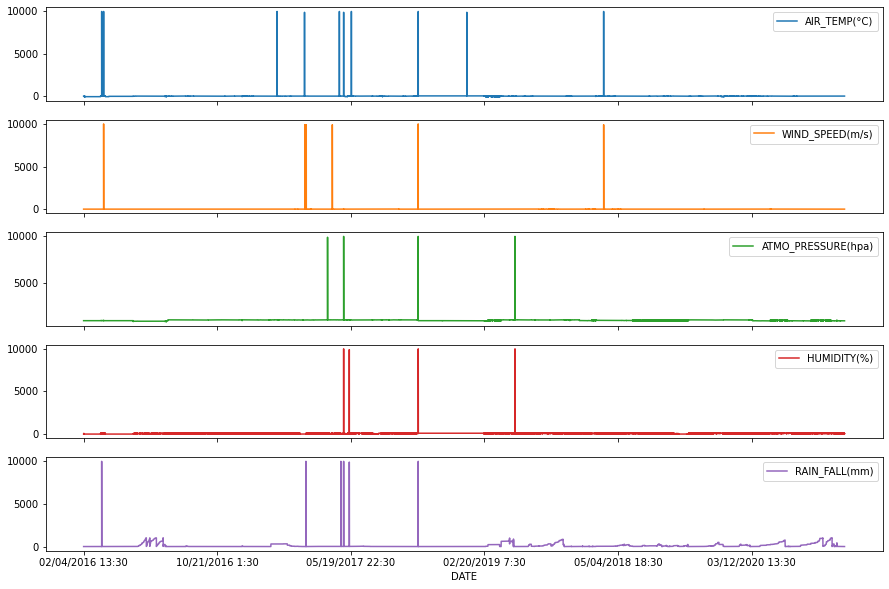

In [29]:
df = pd.read_csv(root+'west_bengal_isro.csv')
df['DATE'] = df['DATE(IST)'] + " " + df['TIME(IST)']
df.drop(columns=['@STATION_ID', 'ALTITUDE(m)', 'WIND_DIRECTION(deg)', 'SUN_SHINE(hh:mm)','BATTERY_VOLTAGE(V)','TIME(GMT)', 'DATE(GMT)', 'TIME(IST)', 'DATE(IST)', 'LATITUDE', 'LONGITUDE'])
df.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True,figsize=(15, 10))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63813761d0>,
      dtype=object)

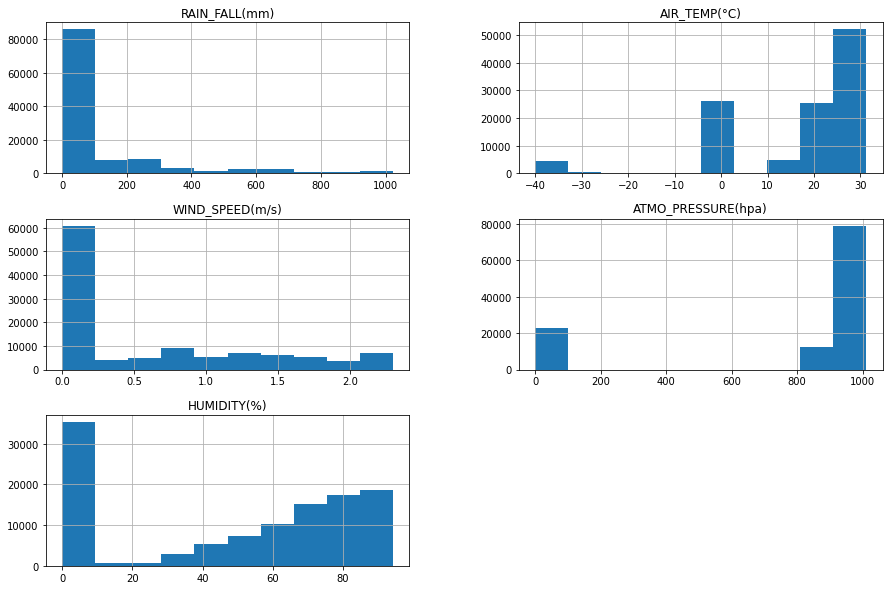

In [30]:
df_input=df[['RAIN_FALL(mm)','AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)']]
for i in df_input.columns:
  if(i == 'RAIN_FALL(mm)'):
    a = df_input[i] > 2000
    df_input[i][a] = 0
  elif (i == 'DATE'):
    continue
  else:
    a = df_input[i].quantile(0.80)
    b = df_input[i] > a
    df_input[i][b] = 0
df_input.hist(figsize = (15, 10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6378fa4a50>,
      dtype=object)

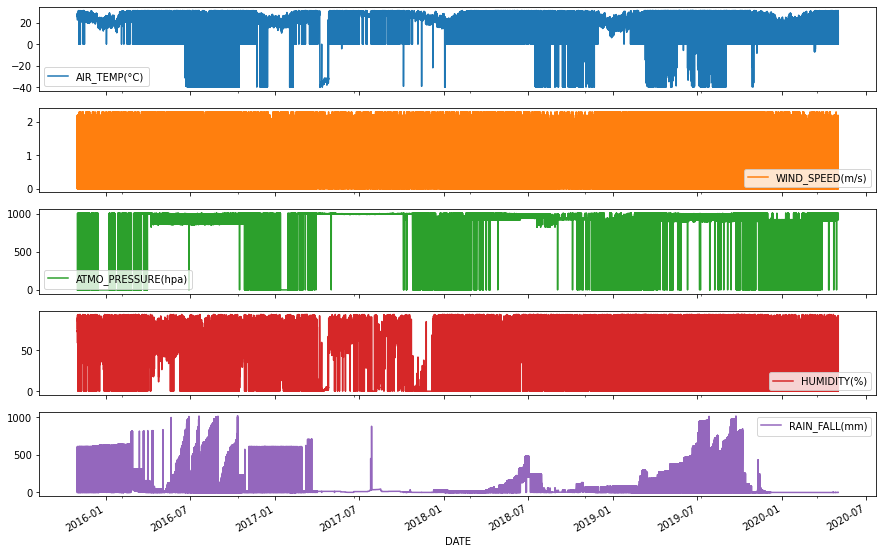

In [31]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
df_input['DATE'] = pd.to_datetime(df['DATE'], format="%m/%d/%Y %H:%M")
df_input.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True, figsize=(15, 10))

In [32]:
df_input.to_csv(root+'corrected/west_bengal.csv', header=True, index=False)
df_input.describe()

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
count,113899.000000,113899.000000,113899.000000,113899.000000,113899.000000
mean,98.056954,16.454524,0.592694,766.725103,48.380487
std,190.582156,16.060579,0.747329,384.444150,35.407244
min,0.000000,-40.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,900.800000,0.100000
50%,8.000000,23.000000,0.000000,925.000000,61.000000
75%,97.000000,27.900000,1.200000,999.800000,79.700000
max,1023.000000,31.200000,2.300000,1010.400000,94.200000


## Data split
Split the data into training and test set 

In [33]:
datelist = df_input['DATE']
print(datelist)
features=data_scaled
target=data_scaled[:,0]

0        2016-02-04 13:30:00
1        2016-02-04 14:30:00
2        2016-02-04 15:30:00
3        2016-02-04 16:30:00
4        2016-02-04 17:30:00
                 ...        
113894   2020-04-25 12:30:00
113895   2020-04-26 08:30:00
113896   2020-04-26 09:30:00
113897   2020-04-26 12:30:00
113898   2020-04-27 11:30:00
Name: DATE, Length: 113899, dtype: datetime64[ns]


In [34]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)

In [35]:
print(x_train.shape)
print(y_train.shape)

(91119, 5)
(91119,)


In [36]:
print(x_test.shape)
print(y_test.shape)

(22780, 5)
(22780,)


In [37]:
win_length=10
batch_size=32
num_features=5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [38]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
# model.add(tf.keras.layers.LSTM(128, return_sequences=True))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
# model.add(tf.keras.layers.Dropout(0.3)) 
# model.add(tf.keras.layers.LSTM(64, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.3)) 
# model.add(tf.keras.layers.Dense(1))

In [39]:
# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# model.compile(loss=tf.losses.MeanSquaredError(),
#               optimizer=tf.optimizers.Adam())
# tb = TensorBoard('logs')
# history = model.fit(train_generator, epochs=50,
#                     callbacks=[es, rlr, mcp, tb], validation_data=test_generator,
#                     shuffle=False, verbose=1, batch_size=256)
model = tf.keras.models.load_model(root+'week5_lstm_isro.h5')

In [40]:
# model.save(root+'week5_lstm_isro.h5')

In [41]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist.iloc[-1], periods=10000, freq='3h').tolist()

In [42]:
temp_predict = model.predict(test_generator)

In [43]:
temp_predict

array([[-0.4596333 ],
       [-0.45995998],
       [-0.4581821 ],
       ...,
       [-0.4694457 ],
       [-0.46892387],
       [-0.46952534]], dtype=float32)

In [44]:
temp_predict.size

22770

In [45]:
split = train_generator.end_index
date_train =datelist[:split]
date_test =datelist[split:]

In [46]:
date_test.shape

(22781,)

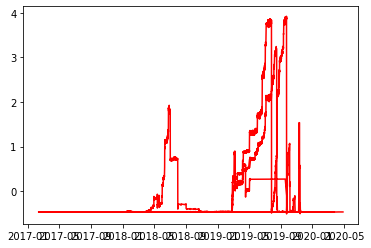

In [47]:
plt.plot(date_test[11:],temp_predict, 'r')

In [ ]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [48]:
# Perform predictions
predictions_future = model.predict(train_generator[-10000:])

predictions_train = model.predict(train_generator[win_length:])

TypeError: ignored

In [ ]:
# Inverse the predictions to original measurements

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['RAIN_FALL(mm)']).set_index(pd.to_datetime(datelist_future,format="%m/%d/%Y %H:%M"))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['RAIN_FALL(mm)']).set_index(pd.to_datetime(datelist[2 * n_past + n_future -1:], format="%m/%d/%Y %H:%M"))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
# PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)
PREDICTIONS_FUTURE['DATE'] = PREDICTIONS_FUTURE.index
PREDICTION_TRAIN['DATE'] = PREDICTION_TRAIN.index
PREDICTION_TRAIN.head(3)

In [ ]:
PREDICTION_TRAIN.info()

In [ ]:
# df = df.set_index(datelist)[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True, figsize=(15, 10))

In [ ]:
df = df_input

In [ ]:
# Set plot size 
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = datelist[0]

# plt.plot(PREDICTIONS_FUTURE['DATE'], PREDICTIONS_FUTURE['RAIN_FALL(mm)'], color='r', label='Predicted Rainfall(mm)')
# plt.plot(PREDICTION_TRAIN['DATE'], PREDICTION_TRAIN['RAIN_FALL(mm)'], color='orange', label='Training predictions')
plt.plot(df['DATE'], df['RAIN_FALL(mm)'], color='b', label='Actual Rainfall(mm)')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Rainfall (mm)', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Rainfall (mm)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [ ]:
plt.plot(PREDICTION_TRAIN['RAIN_FALL(mm)'])